In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

Let's use xarray to analyse some model results.

In [2]:
w = xr.open_dataset('model_results.nc')
w

<xarray.Dataset>
Dimensions:      (time: 984, x: 56, z: 107)
Coordinates:
  * x            (x) float32 500.0 1500.0 2500.0 ... 46562.51 47337.51 48112.51
  * z            (z) float32 597.75 598.25 598.75 ... 649.75 650.25 650.75
  * time         (time) datetime64[ns] 2015-06-01 ... 2015-10-01T21:00:00
    seg          (x) int64 ...
Data variables:
    uvel         (time, x, z) float64 ...
    wvel         (time, x, z) float64 ...
    temperature  (time, x, z) float64 ...
    turbidity    (time, x, z) float64 ...
    water_level  (time, x) float64 ...
    dy           (x, z) float32 ...
    dx           (x) float32 ...
    dz           (z) float32 ...

The data set has two spatial dimensions plus time. The data was output at 3-hr intervals from 01 June to 01 October 2015. The grid consists of 56 horizontal segments and 107 vertical layers. We have 8 variables.

Let's have a look at the grid.

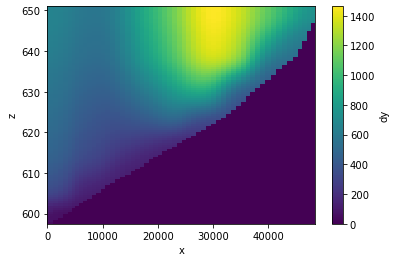

In [5]:
w.dy.plot(x = 'x', y = 'z')

Suppose we're interested in the temperature on 15 July 2015 at 12 noon. We can plot that snapshot like this.

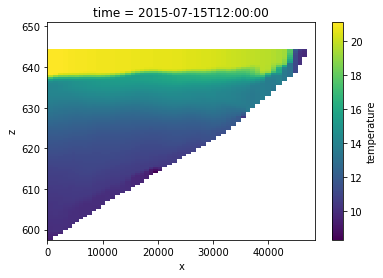

In [10]:
w.temperature.sel(time = '2015-07-15 12:00').plot(x='x', y='z')


What if we're interested in the vorticity, but this variable isn't in the data set. We can compute this derived quantities using the derivatives of the horizontal and vertical velocity.

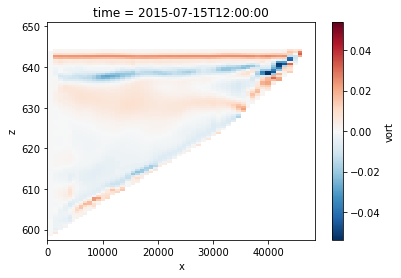

In [13]:
w['vort'] = w.uvel.differentiate('z') - w.wvel.differentiate('x')

w.vort.sel(time = '2015-07-15 12:00').plot(x='x', y='z')


So far, we've looked at snapshots at a single time. But what if we want to get a time series at a specific distance. Our mooring concides with horizontal segment that's 4.75 km from the dam. So lets get a time series from there.

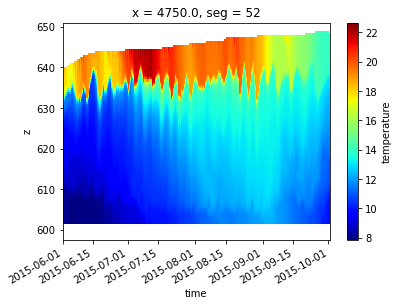

In [16]:
w.temperature.sel(x = 4650, method = 'nearest').plot(x='time', cmap = 'jet')

But what if we want to know the values at exactly 5 km from the dam? If that's between grid points, we have to interpolate. And say we only want to see the month of July.

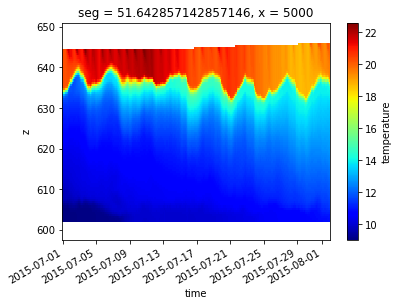

In [18]:
start = '2015-07-01'; end = '2015-08-01'
w.temperature.interp(x = 5000).sel(time = slice(start, end)).plot(x='time', cmap = 'jet')

What if we want the stage-storage volume and surface area curves? We have the grid, so we can make them.

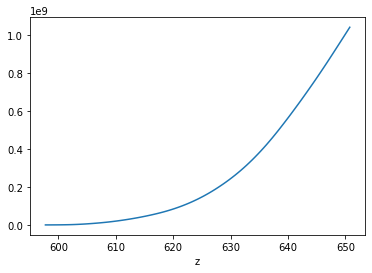

In [35]:
(w['dz']*w['dx']*w['dy']).sum(dim = 'x').cumsum().plot(x='z')


What if we want to calculate the volume of water in the reservoir that has a turbidity below some threshold. Say this is a drinking water requirement. We can use the xr.where method.

In [38]:
da = xr.where(w.turbidity < 5, 1, 0)
da * ds.dx*ds

<xarray.DataArray 'turbidity' (time: 984, x: 56, z: 107)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * x        (x) float32 500.0 1500.0 2500.0 ... 46562.51 47337.51 48112.51
  * z        (z) float32 597.75 598.25 598.75 599.25 ... 649.75 650.25 650.75
  * time     (time) datetime64[ns] 2015-06-01 ... 2015-10-01T21:00:00
    seg      (x) int64 57 56 55 54 53 52 51 50 49 48 ... 11 10 9 8 7 6 5 4 3 2

In July, the bottom of the epilimnion closely follows the 17 degree isotherm. Let's compute this isotherm and plot it as a function of horiztontal distance and time.

Let's plot the epilimnion depth, hepi, instead of the epilimnion elevation, zepi, and let's only look at the horizontal distance from the dam to 30 km upstream.